In [1]:
import pandas as pd
import numpy as np

#Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Import the modules for simulating data and for plotting the ACF and PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARIMA

# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Auto Arima Model Choosing
import pmdarima as pm

# SARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import the origincal dataset
gp = pd.read_csv("E:/Yipitdata/Q4_2013_Groupon_North_America_Data_XLSX.csv",index_col=False)
gp.drop(gp.columns[gp.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)

In [2]:
### Exploratory Analysis
# Overview of the dataset
gp.head()

,Deal ID,Units Sold,Billings,Start Date,Deal URL,Segment,Inventory Type
0,gr-millevois-tire-service-center,0.0,0.0,11/21/2011,http://www.groupon.com/deals/gr-millevois-tire...,Local,Third - Party
1,gr-manakeesh-cafe-bakery,0.0,0.0,11/21/2011,http://www.groupon.com/deals/gr-manakeesh-cafe...,Local,Third - Party
2,gr-phoenix-salon-and-spa,0.0,0.0,11/21/2011,http://www.groupon.com/deals/gr-phoenix-salon-...,Local,Third - Party
3,gr-hands-in-motion,0.0,0.0,11/21/2011,http://www.groupon.com/deals/gr-hands-in-motion,Local,Third - Party
4,dc-fd2-bartending-college-allentown-reading,86.8,4253.2,6/6/2012,http://www.groupon.com/deals/dc-fd2-bartending...,Local,Third - Party


In [3]:
# Check for the size of the dataset
gp.shape

(138534, 7)

In [4]:
# Check is there any missing value in every column
gp.isnull().any()
# No "missing values" in the dataset (No consider Oct 20 to Oct 30 2013.)

Deal ID           False
Units Sold        False
Billings          False
Start Date        False
Deal URL          False
Segment           False
Inventory Type    False
dtype: bool

In [5]:
# Chcek the data type in every column
print(gp.dtypes)

Deal ID            object
Units Sold        float64
Billings          float64
Start Date         object
Deal URL           object
Segment            object
Inventory Type     object
dtype: object


In [6]:
# Check the distinct level of Segment and Inventory type column.
print(gp.Segment.unique())
print(gp['Inventory Type'].unique())

['Local' 'Goods' 'Travel']
['Third - Party' 'First - Party']


In [7]:
# Check for the duplicated rows
DuplicatedID = gp[gp.duplicated(['Deal ID'])]
DuplicatedURL = gp[gp.duplicated(['Deal URL'])]
print(DuplicatedID)
print(DuplicatedURL)
# There is no duplicated row in the dataset.

Empty DataFrame
Columns: [Deal ID, Units Sold, Billings, Start Date, Deal URL, Segment, Inventory Type]
Index: []
Empty DataFrame
Columns: [Deal ID, Units Sold, Billings, Start Date, Deal URL, Segment, Inventory Type]
Index: []


In [8]:
# There are some data with extremely small number in Units Sold and Billings sold, I assume they equal to 0.
# When I checked the dataset, I found that there are some data have small units sold but at the same time have large amount of gross billing. I assume these are bad data.
# Also, if units sold or billings are 0, it won't affect the final estimated gross billing result. (Don't consider the number of new deal)
# Therefore, here I set these rows to be 0 and will remove in the next several steps.
gp[gp['Units Sold'].abs() < 0.0001] = 0
gp[gp['Billings'].abs()<0.0001]=0
gp[(gp['Units Sold']==0) & (gp['Billings']!=0)] = 0

In [9]:
# Generate 4 new dataframes, local, travel, goods and tg. Each of them includes corresponding information, for examle, local is
# a subset of the original dataset that only includes information about "local"
local=gp[gp['Segment']=='Local']
travel=gp[gp['Segment']=='Travel']
goods=gp[gp['Segment']=='Goods']
tg = gp[(gp['Segment']=='Goods')|(gp['Segment']=='Travel')]
collect=gp[(gp['Segment']=='Local')|(gp['Segment']=='Goods')|(gp['Segment']=='Travel')]

In [10]:
gp.shape

(138534, 7)

In [11]:
travel.shape

(2251, 7)

In [12]:
goods.shape

(14634, 7)

In [13]:
tg.shape

(16885, 7)

In [14]:
local.shape

(94615, 7)

In [15]:
#Convert the start date into datetime so that it can become the time index and be aggregated when build up time series model.
local['Start Date'] = pd.to_datetime(local['Start Date'])
travel['Start Date'] = pd.to_datetime(travel['Start Date'])
goods['Start Date'] = pd.to_datetime(goods['Start Date'])
tg['Start Date'] = pd.to_datetime(tg['Start Date'])

# Generate a subdataset that contain all billings information and start date, for plotting
collect['Start Date'] = pd.to_datetime(collect['Start Date'])

<ipython-input-15-34aa4a33f315>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local['Start Date'] = pd.to_datetime(local['Start Date'])
<ipython-input-15-34aa4a33f315>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel['Start Date'] = pd.to_datetime(travel['Start Date'])
<ipython-input-15-34aa4a33f315>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [16]:
# Select units sold, billings and start date out
local_s=local[["Units Sold","Billings","Start Date"]]
travel_s=travel[["Units Sold","Billings","Start Date"]]
goods_s=goods[["Units Sold","Billings","Start Date"]]
tg_s=tg[["Units Sold","Billings","Start Date"]]
collect_s=collect[["Units Sold", "Billings","Start Date"]]

In [17]:
# Set the Start date as the time index
local_s= local_s.set_index('Start Date')
travel_s = travel_s.set_index('Start Date')
goods_s = goods_s.set_index('Start Date')
tg_s = tg_s.set_index('Start Date')
# Set the Start date as the time index for the subdataset collect
collect_s=collect_s.set_index('Start Date')

In [18]:
# Aggregate on Month and plot to see the pattern
tslocal=local_s.resample('M').sum()
tstravel=travel_s.resample('M').sum()
tsgoods=goods_s.resample('M').sum()
tstg=tg_s.resample('M').sum()
tscollect=collect_s.resample('M').sum()

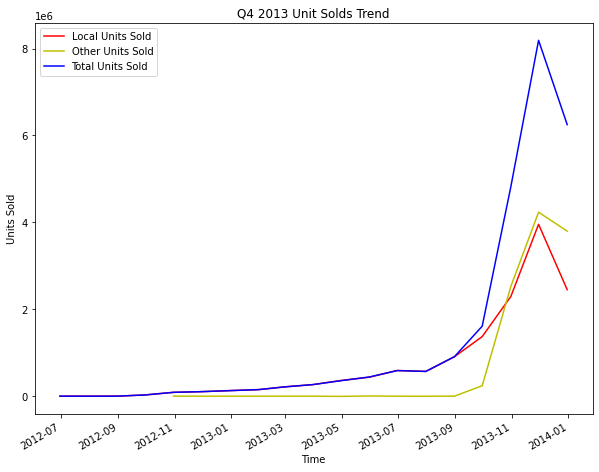

In [19]:
# The data shows there is a rapid increase after September 2013 in local units sold and goods units sold
with pd.plotting.plot_params.use('x_compat', True):
    fig,axs=plt.subplots(1,1,figsize=(10,8))
    tslocal['Units Sold'].plot(color='r',label='Local Units Sold')
    tstg['Units Sold'].plot(color='y',label='Other Units Sold')
    tscollect['Units Sold'].plot(color='b',label='Total Units Sold')
    plt.title('Q4 2013 Unit Solds Trend')
    plt.xlabel('Time')
    plt.ylabel('Units Sold')
    plt.legend()

    plt.show()

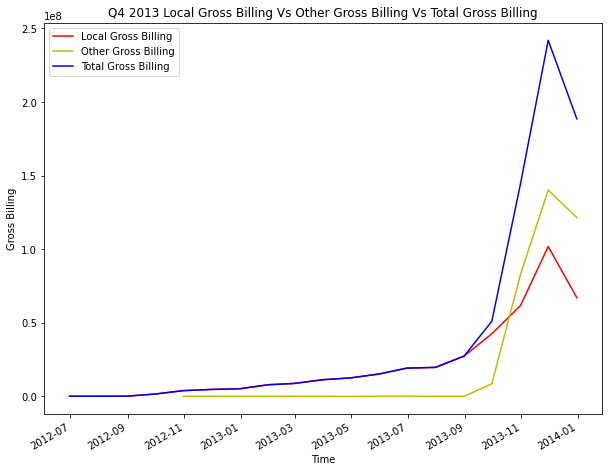

In [20]:
# The data shows there is a rapid increase after September 2013 in local gross billing, goods gross billing and travel gross builling
with pd.plotting.plot_params.use('x_compat', True):
   #tslocal['Billings'].plot(color='r')
   #tstravel['Billings'].plot(color='g')
   #tsgoods['Billings'].plot(color='b')
   #tstg['Billings'].plot(color='y')
    
    fig,axs=plt.subplots(1,1,figsize=(10,8))
    tslocal['Billings'].plot(color='r',label='Local Gross Billing')
    tstg['Billings'].plot(color='y',label='Other Gross Billing')
    tscollect['Billings'].plot(color='b',label='Total Gross Billing')
    plt.title('Q4 2013 Local Gross Billing Vs Other Gross Billing Vs Total Gross Billing')
    plt.xlabel('Time')
    plt.ylabel('Gross Billing')
    plt.legend()

    plt.show()

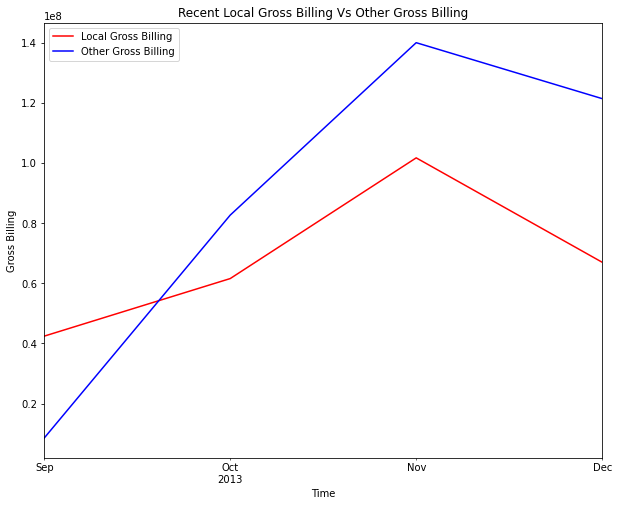

In [21]:
# Zoom in and have a look the trend of gross billing from September to December
lcpm=tslocal.loc['2013-09-01':'2013-12-31']
tgvpm=tstg.loc['2013-09-01':'2013-12-31']

fig,axs=plt.subplots(1,1,figsize=(10,8))
lcpm['Billings'].plot(color='r',label='Local Gross Billing')
tgvpm['Billings'].plot(color='b',label='Other Gross Billing')
plt.title('Recent Local Gross Billing Vs Other Gross Billing')
plt.xlabel('Time')
plt.ylabel('Gross Billing')
plt.legend()

plt.show()

In [22]:
# Aggregate on date and plot to see the pattern
tslocal_d=local_s.resample('D').sum()
tstravel_d=travel_s.resample('D').sum()
tsgoods_d=goods_s.resample('D').sum()
tstg_d=tg_s.resample('D').sum()
collect_d=collect_s.resample('D').sum()

Text(0, 0.5, 'Gross Billing')

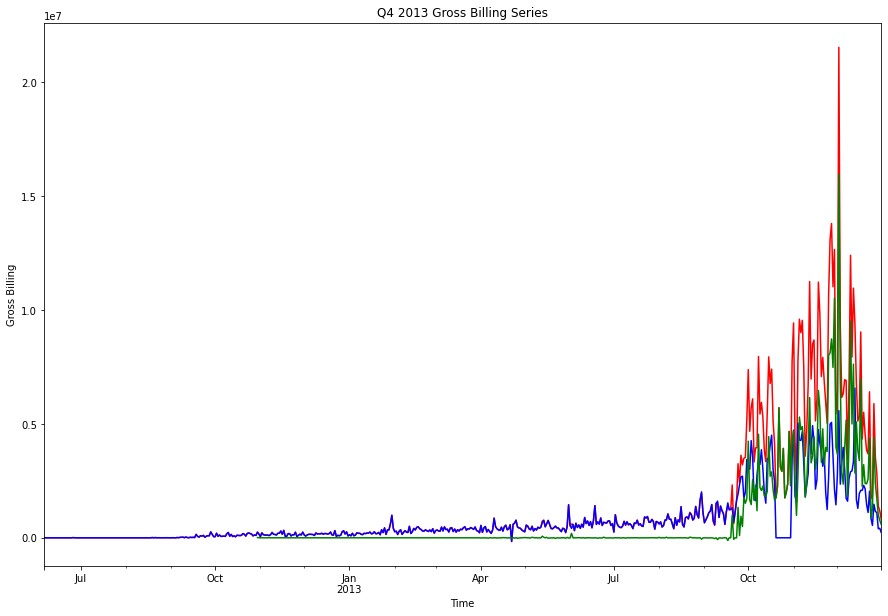

In [23]:
# Plot the total billing gross time series and have a better idea about its trend and pattern
collect_d['Billings'].plot(color='r')
tslocal_d['Billings'].plot(color='b')
tstg_d['Billings'].plot(color='g')
plt.gcf().set_size_inches((15, 10)) 
plt.title('Q4 2013 Gross Billing Series')
plt.xlabel('Time')
plt.ylabel('Gross Billing')


# Base on the gross billing plot, we can see the billings are small before late September, which make sense because the time here
# indicates the start date of the deals. The popularity level of a deal will drop over time. We are focuing on Q4 2013, which starts
# from Octobor 2013 to Decemebr 2013. Therefore, those new deals that starts near October or after October will have a higher gross
# billings, and deals started from last year will have very low gross billing. The other thing is, the gross billing drop around
# October 20th to October 30th represent there are some missing data point there and need to be imputed or estimated. There is a
# peak around mid December, base on the plot show below, other gross billing has a significant amount of countribution to this peak
# which may indicates there were a lot of customer bought travel service for their festival travel or bought goods for their family
# during the festival season.

Text(0, 0.5, 'Gross Billing')

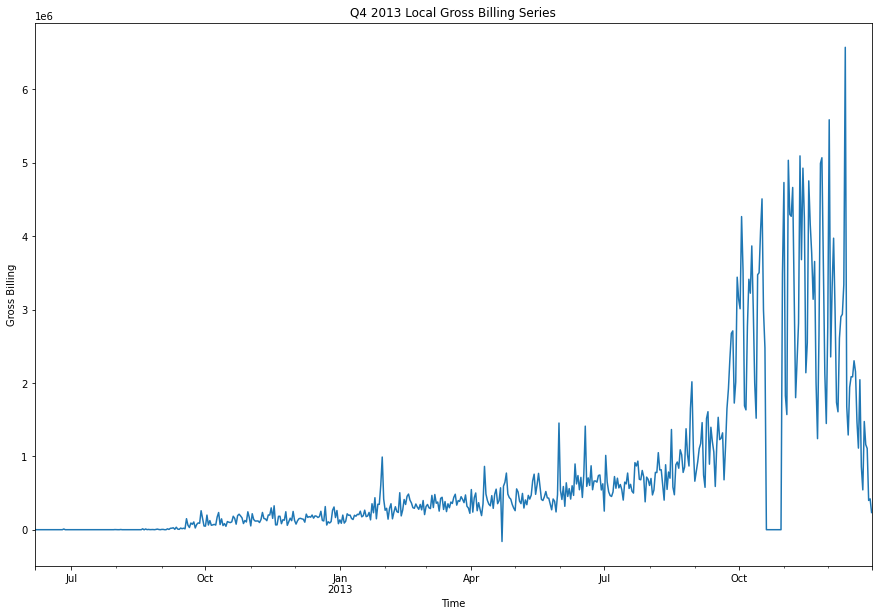

In [24]:
tslocal_d['Billings'].plot()
plt.gcf().set_size_inches((15, 10)) 
plt.title('Q4 2013 Local Gross Billing Series')
plt.xlabel('Time')
plt.ylabel('Gross Billing')

Text(0, 0.5, 'Gross Billing')

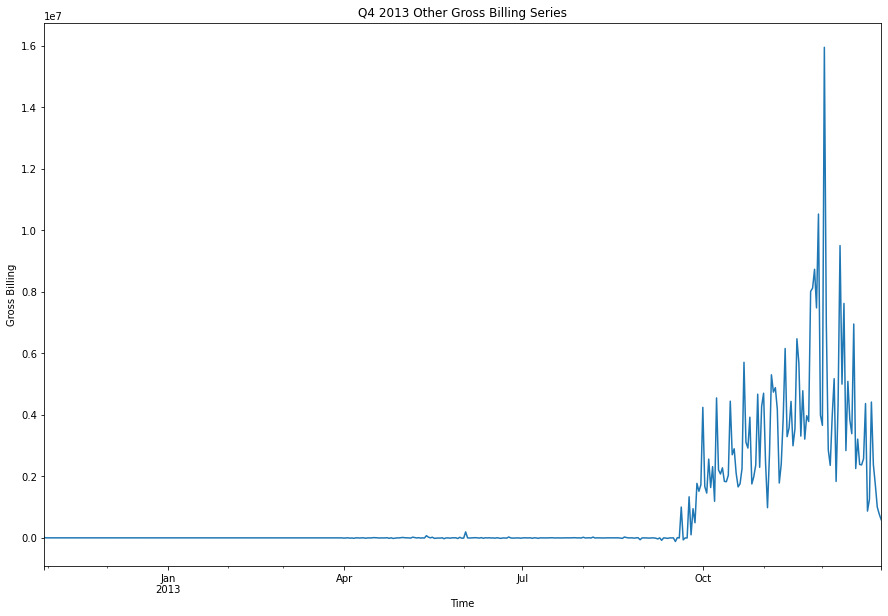

In [25]:
tstg_d['Billings'].plot()
plt.gcf().set_size_inches((15, 10)) 
plt.title('Q4 2013 Other Gross Billing Series')
plt.xlabel('Time')
plt.ylabel('Gross Billing')

Text(0, 0.5, 'Gross Billing')

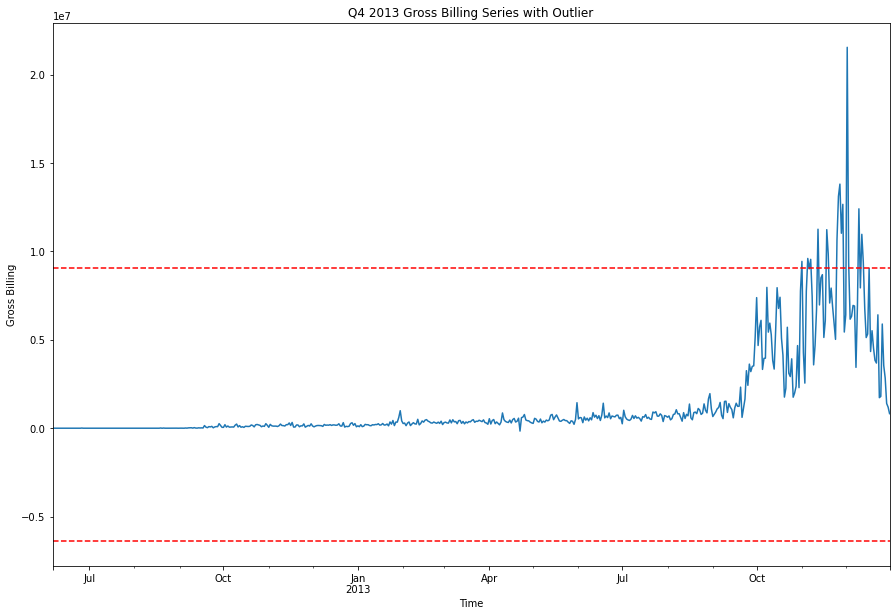

In [26]:
# Indicates the outlier's in the dataset
fig, axs = plt.subplots(figsize=(15, 10))

# Calculate the mean / standard deviation for the data
this_mean = collect_d['Billings'].mean()
this_std = collect_d['Billings'].std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
collect_d['Billings'].plot(ax=axs)
axs.axhline(this_mean + this_std * 3, ls='--', c='r')
axs.axhline(this_mean - this_std * 3, ls='--', c='r')
plt.title('Q4 2013 Gross Billing Series with Outlier')
plt.xlabel('Time')
plt.ylabel('Gross Billing')
# Although there are a large amount of outliers in November and December, since they are actually exsist data, I choose to keep
# them in the dataset.

Text(0, 0.5, 'Units Sold')

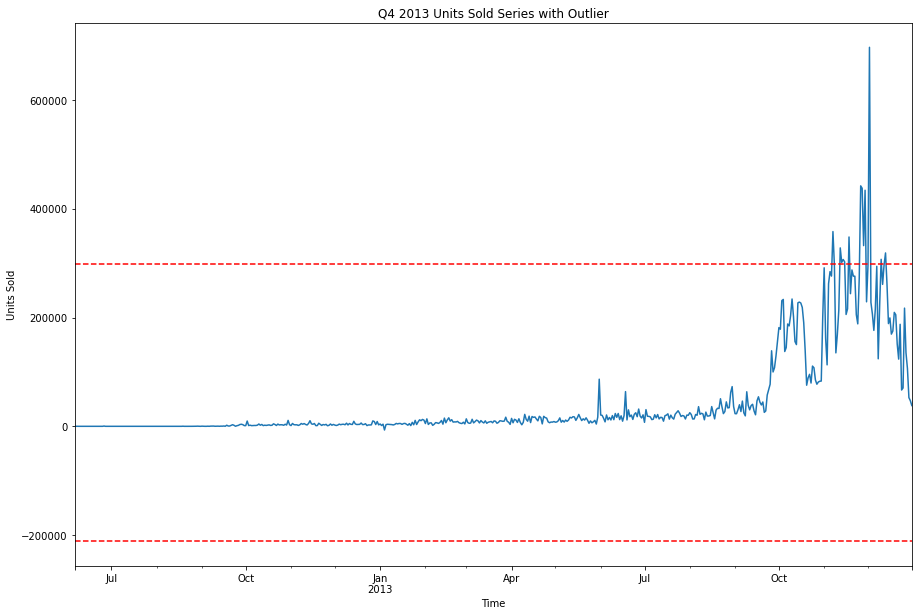

In [27]:
# Indicates the outlier's in the dataset
fig, axs = plt.subplots(figsize=(15, 10))

# Calculate the mean / standard deviation for the data
US_mean = collect_d['Units Sold'].mean()
US_std = collect_d['Units Sold'].std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
collect_d['Units Sold'].plot(ax=axs)
axs.axhline(US_mean + US_std * 3, ls='--', c='r')
axs.axhline(US_mean - US_std * 3, ls='--', c='r')
plt.title('Q4 2013 Units Sold Series with Outlier')
plt.xlabel('Time')
plt.ylabel('Units Sold')
# Although there are a large amount of outliers in November and December, since they are actually exsist data, I choose to keep
# them in the dataset.

In [28]:
# To better understand the relationship between different types of billings, calculate the correlation between the gross billing of 
# local and travel, local and goods, and local and (travel + goods)
CorrLtg=tslocal_d['Billings'].corr(tstg_d['Billings'])
CorrLt=tslocal_d['Billings'].corr(tstravel_d['Billings'])
CorrLg=tslocal_d['Billings'].corr(tsgoods_d['Billings'])
print("Correlation Coefficient between local gross billing and other gross billing:" , CorrLtg)
print("Correlation Coefficient between local gross billing and travel gross billing:", CorrLt)
print("Correlation Coefficient between local gross billing and goods gross billing:", CorrLg)
# The result shows the gross billing of local has the highest positive correlation with the gross billing of travel+ goods

Correlation Coefficient between local gross billing and other gross billing: 0.7309675244744442
Correlation Coefficient between local gross billing and travel gross billing: 0.37180866211275604
Correlation Coefficient between local gross billing and goods gross billing: 0.7064214337487611


In [29]:
# To better understand the relationship between different types of units sold, generate their correlation coefficient
CorrULtg=tslocal_d['Units Sold'].corr(tstg_d['Units Sold'])
CorrULt=tslocal_d['Units Sold'].corr(tstravel_d['Units Sold'])
CorrULg=tslocal_d['Units Sold'].corr(tsgoods_d['Units Sold'])
print(CorrULtg)
print(CorrULt)
print(CorrULg)
# The result shows the units sold of local has the highest positive correlation with the units sold of travel+ goods

0.7114835808771619
0.38677820780678934
0.7018582514066036


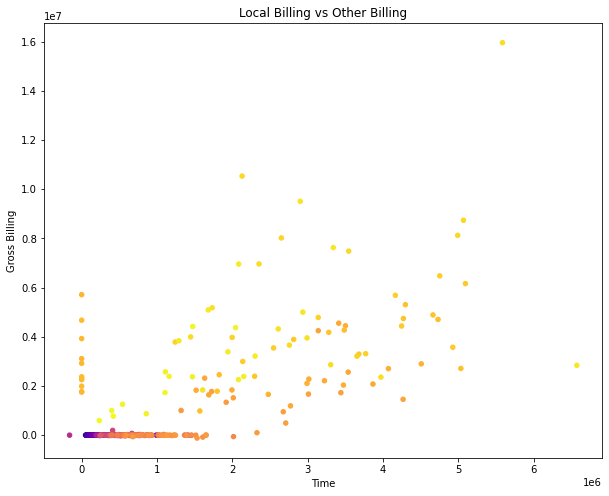

In [30]:
# Generate a scatter plot for the relationship between the local gross billing and the other gross billing
Re=pd.concat([tslocal_d, tstg_d], axis=1, join='outer')

Re.columns=['Local_Units_Sold','Local_Billings','TG_Units_Sold','TG_Billings']
Re=Re.drop(columns=['Local_Units_Sold','TG_Units_Sold'])

# Take a look at the relationship between the local gross billing and other gross billing

Re.plot.scatter('Local_Billings','TG_Billings',c=Re.index, colorbar=False,colormap='plasma')
plt.gcf().set_size_inches((10, 8)) 
plt.title('Local Billing vs Other Billing')
plt.xlabel('Time')
plt.ylabel('Gross Billing')
plt.show()

# As you can see in this scatter plot, many points are locates at the lower left corner as a straight line on both x-axis and y-axis
# Which means when either one of the billing increase, the other billing isn't affected.
# We can say there is somehow positive correlation between travel and goods gross billing with the local gross billing, but is not very strong.
# Therefore we can't directly estimate the local gross billing values with travel and goods gross billing value although they have a 0.731 correlation coefficient.

In [31]:
# Zoom in on the recent data. 
lcp=tslocal_d.loc['2013-09-01':'2013-12-31']
tgvp=tstg_d.loc['2013-09-01':'2013-12-31']

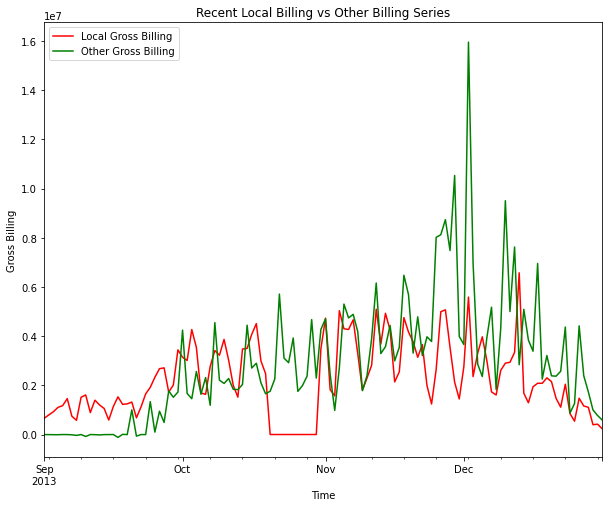

In [32]:
lcp['Billings'].plot(color='r',label="Local Gross Billing")
tgvp['Billings'].plot(color='g',label="Other Gross Billing")
plt.gcf().set_size_inches((10, 8))
plt.legend()
plt.title('Recent Local Billing vs Other Billing Series')
plt.xlabel('Time')
plt.ylabel('Gross Billing')
plt.show()

In [33]:
# What is the correlation between local gross billing and other gross billing
lcpa=tslocal_d.loc['2013-09-19':'2013-10-19']
tgvpa=tstg_d.loc['2013-09-19':'2013-10-19']
print(lcpa['Billings'].corr(tgvpa['Billings']))

lcpb =tslocal_d.loc['2013-10-31':'2013-11-15']
tgvpb = tstg_d.loc['2013-10-31':'2013-11-15']

print(lcpb['Billings'].corr(tgvpb['Billings']))

0.6070829836516749
0.7528064920785484


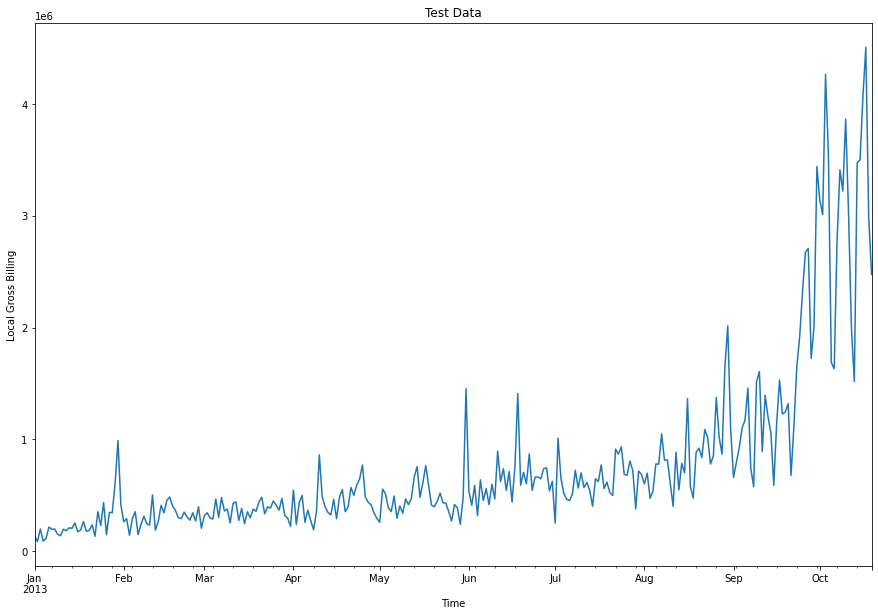

In [34]:
# Select part of the time series out and make prediction on the missing values of Oct 20th to Oct 30th data.
# Here, I select the data from 2012-08-19, because there are a lot of 0 local gross billing before August 19th 2012.
# Therefore, I would like to remove those 0's because they will affect the time series model.
# There are some gross billing equal or less than after August 19th 2012, I replace these values by local gross billing median,
# so that I can do log transformation and diffrence to the data to make it stational.
lcp_ana=tslocal_d.loc['2013-01-01':'2013-10-19']
lcp_ana=lcp_ana.mask(lcp_ana['Billings']<=0).fillna(lcp_ana['Billings'].median())
lcp_ana['Billings'].plot()
plt.gcf().set_size_inches((15, 10))
plt.title('Test Data')
plt.xlabel('Time')
plt.ylabel('Local Gross Billing')
plt.show()
# The time series plot shows a clear trend and a increase variance in this time series. Therefore, I use log transformation and then take
# the first difference to make it a stationary time series.

In [35]:
lcp_ana['Billings']

Start Date
2013-01-01    1.336714e+05
2013-01-02    8.738314e+04
2013-01-03    1.991381e+05
2013-01-04    8.979850e+04
2013-01-05    1.155524e+05
                  ...     
2013-10-15    3.501416e+06
2013-10-16    4.072212e+06
2013-10-17    4.507996e+06
2013-10-18    2.991175e+06
2013-10-19    2.477089e+06
Freq: D, Name: Billings, Length: 292, dtype: float64

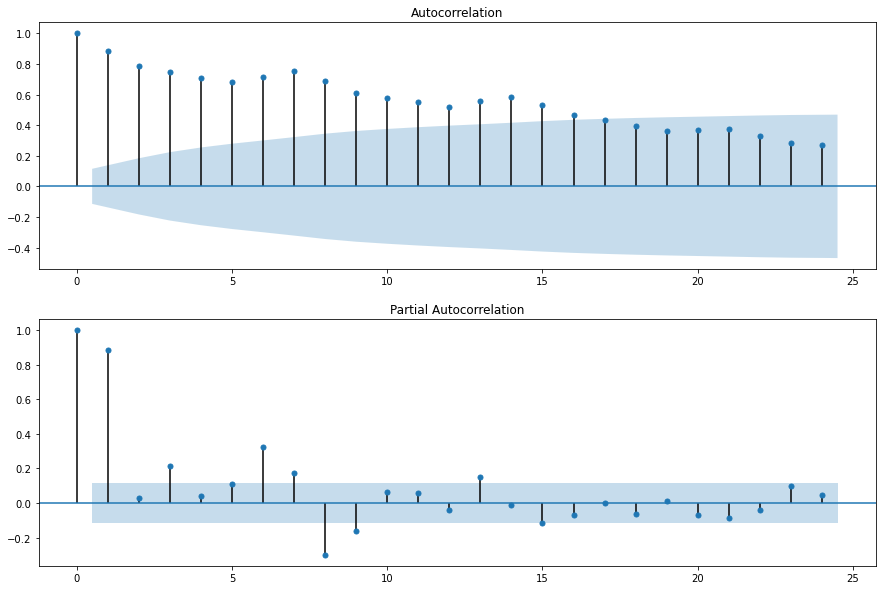

In [36]:
# Plot the ACF and PACF on the same page for the original series
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(lcp_ana['Billings'], lags=24, ax=axes[0])

# Plot the PACF
plot_pacf(lcp_ana['Billings'], lags=24, ax=axes[1])
plt.gcf().set_size_inches((15, 10))
plt.show()

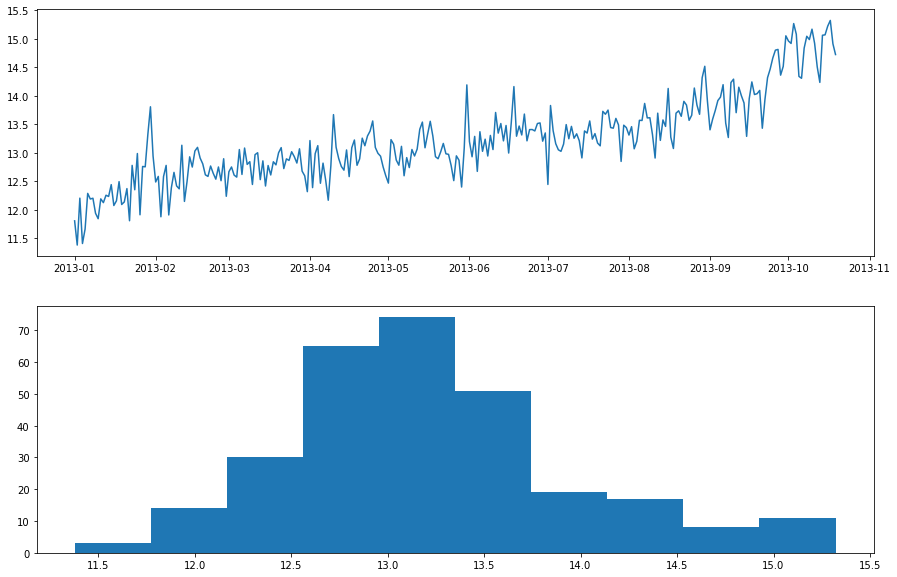

Start Date
2013-01-01         NaN
2013-01-02   -0.425082
2013-01-03    0.823696
2013-01-04   -0.796430
2013-01-05    0.252156
                ...   
2013-10-15    0.007561
2013-10-16    0.151019
2013-10-17    0.101666
2013-10-18   -0.410186
2013-10-19   -0.188582
Freq: D, Name: Billings, Length: 292, dtype: float64


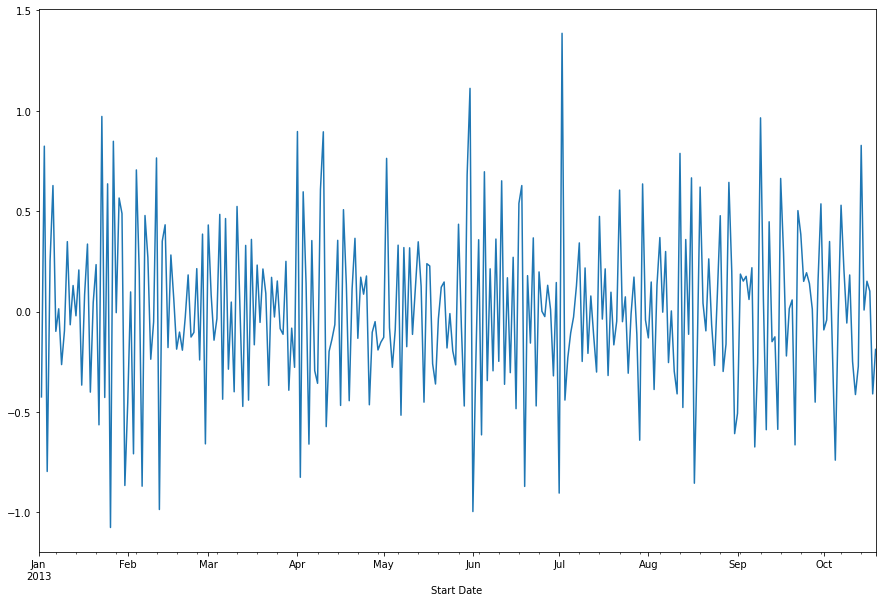

In [37]:
# Making the log transformation to the time series
lt = np.log(lcp_ana['Billings'])
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(lt)
# histogram
plt.subplot(212)
plt.hist(lt)
plt.gcf().set_size_inches((15, 10))
plt.show()
# There is still a clear increasing trend in the data, but the difference in variance has been significantly reduced.
# Take the first difference to the loged series to make it stationary
fdl = lt.diff()
#Check the stationarity of first difference series
print(fdl)
fdl.plot()
plt.gcf().set_size_inches((15, 10))
plt.show()

In [38]:
# Drop the NaN value in the first row produced by the first difference
fdl=fdl.dropna()
resfd=adfuller(fdl)
print('The p-value fof the ADF test is ', resfd[1])
# Base on the ADF result, after the first difference and log transformation the time series is a stationary time series under 95% confidence level.

The p-value fof the ADF test is  4.0531388499849136e-08


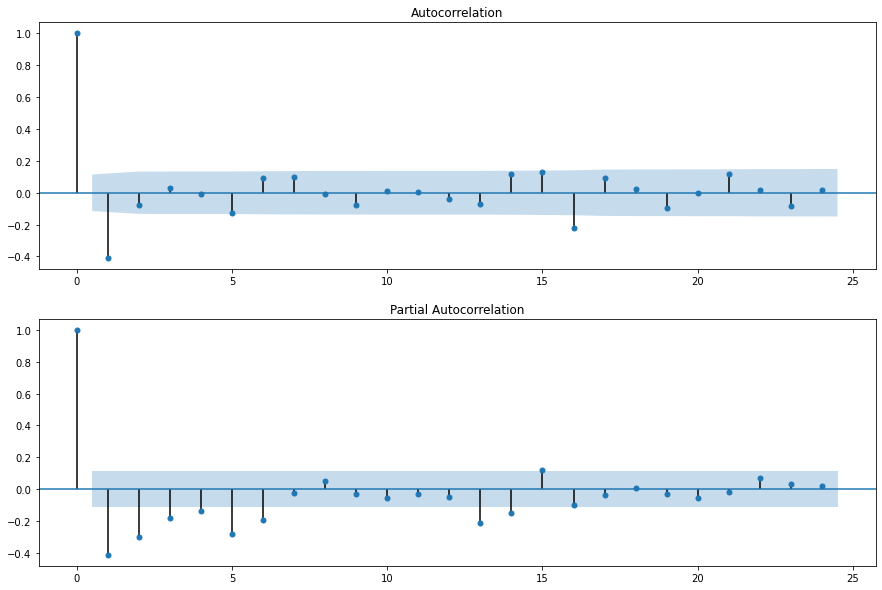

In [39]:
# For fitting the correct ARIMA model to this dataset, we need to take a look at the ACF and PACF first
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(fdl, lags=24, ax=axes[0])

# Plot the PACF
plot_pacf(fdl, lags=24, ax=axes[1])
plt.gcf().set_size_inches((15, 10))
plt.show()

# Both of ACF and PACF slowly decay. ACF is not significant after lag 3 and have a spike at lag 12 and lag 24. PACF slowly decay and have
# a negative spike at lag 11.

In [40]:
# Loop over p and q values from 0-10 to select the best model
selection=[]
for p in range(6):
  
  # Loop over q values from 0-10
    for q in range(6):
      try:
        # Create and fit ARMA(p,q) model
        model = SARIMAX(lt, order=(p,1,q), trend='c')
        results = model.fit()
        # Print p, q, AIC, BIC
        p=p
        q=q
        AIC=results.aic
        BIC = results.bic
        print(p, q, results.aic, results.bic)
        selection.append((p,q,AIC,BIC))

      except:
        print(p,q,None,None)       

0 0 304.0661279199181 311.41277445426107
0 1 191.05720067727287 202.07717047878737
0 2 188.03535931160337 202.72865238028933
0 3 190.0112342981031 208.37785063396055
0 4 191.81951218584388 213.85945178887283


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


0 5 193.7802445565626 219.49350742676305
1 0 252.43413995621268 263.45410975772717
1 1 188.01231703369012 202.70561010237608
1 2 189.99897217782393 208.3655885136814
1 3 191.99717769599016 214.03711729901912


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1 4 193.8152989918222 219.52856186202266


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1 5 195.4522479607126 224.83883409808456
2 0 227.74064667002898 242.43393973871494
2 1 190.00237493542357 208.36899127128103


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 2 191.97546838988717 214.01540799291612


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2 3 187.63878035425643 213.35204322445688


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2 4 182.91794465512658 212.30453079249853


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2 5 183.62634433113004 216.68625373567346
3 0 220.10704026271205 238.4736565985695
3 1 191.9301318246249 213.97007142765386


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3 2 193.88510168832778 219.59836455852823


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3 3 182.18959538242035 211.5761815197923


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3 4 182.2791660786247 215.33907548316813


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3 5 184.35499953260063 221.08823220431555
4 0 216.64498030557695 238.6849199086059
4 1 193.36501537646674 219.0782782466672


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4 2 195.64073134512108 225.02731748249303


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4 3 185.38487634221738 218.44478574676083


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4 4 184.1544871831031 220.88771985481804


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4 5 185.6257997395195 226.0323556784059
5 0 195.04994377993103 220.76320665013148
5 1 189.3016093343138 218.68819547168576
5 2 188.83385353790942 221.89376294245284


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5 3 185.22203910413575 221.9552717758507


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5 4 185.73157105771895 226.13812699660537
5 5 187.30870812978054 231.38858733583845


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [41]:
cols=['p','q','AIC','BIC']
result = pd.DataFrame(selection, columns=cols)  
# Extract the optimized model's auto regression and moving average parameters
opti=result[result.AIC== result.AIC.min()]
AR=opti['p'].iloc[0]
MA=opti['q'].iloc[0]

print("Best Model AIC:",opti['AIC'].iloc[0])
print("Best Model BIC:",opti['BIC'].iloc[0])

Best Model AIC: 182.18959538242035
Best Model BIC: 211.5761815197923


c:\users\zhaox\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Start Date
2013-01-01    11.792537
2013-01-02    -0.435684
2013-01-03     0.636088
2013-01-04    -0.510095
2013-01-05     0.029951
                ...    
2013-10-15     0.267593
2013-10-16     0.358508
2013-10-17     0.243436
2013-10-18    -0.174257
2013-10-19    -0.166030
Freq: D, Length: 292, dtype: float64
0.2943501861447683
                               SARIMAX Results                                
Dep. Variable:               Billings   No. Observations:                  292
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -83.095
Date:                Tue, 26 May 2020   AIC                            182.190
Time:                        19:32:26   BIC                            211.576
Sample:                    01-01-2013   HQIC                           193.962
                         - 10-19-2013                                         
Covariance Type:                  opg                                         
                 coef    std err     

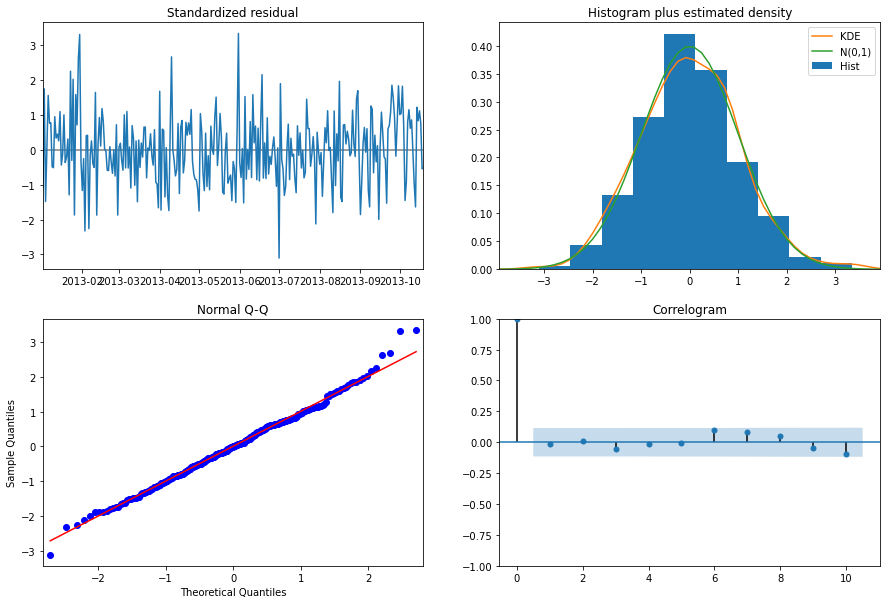

In [42]:

# Create model object
model = SARIMAX(lt, order=(AR,1,MA),trend='c')
# Fit model
result = model.fit()


# Check and print the residual
residual=result.resid
print(residual)
mae=np.mean(np.abs(residual))
print(mae)

result.plot_diagnostics(figsize=(15, 10))
print(result.summary())

# After diagnostics, the residual of the model is white noise because the p-value of Ljung-Box test is 0.1 which larger than
# the critical value 0.05. This means all the features have been capture by this time series model. Also, the model's residual is normally distributed base on the histogram and Q-Q plot below. 

# As shown below, the optimized model for estimating the missing value in the dataset is ARIMA(3,1,3) model with log transformation for the original dataset.

In [43]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Start Date
2013-01-01     0.010540
2013-01-02    11.813679
2013-01-03    11.567171
2013-01-04    11.911066
2013-01-05    11.643847
Freq: D, dtype: float64


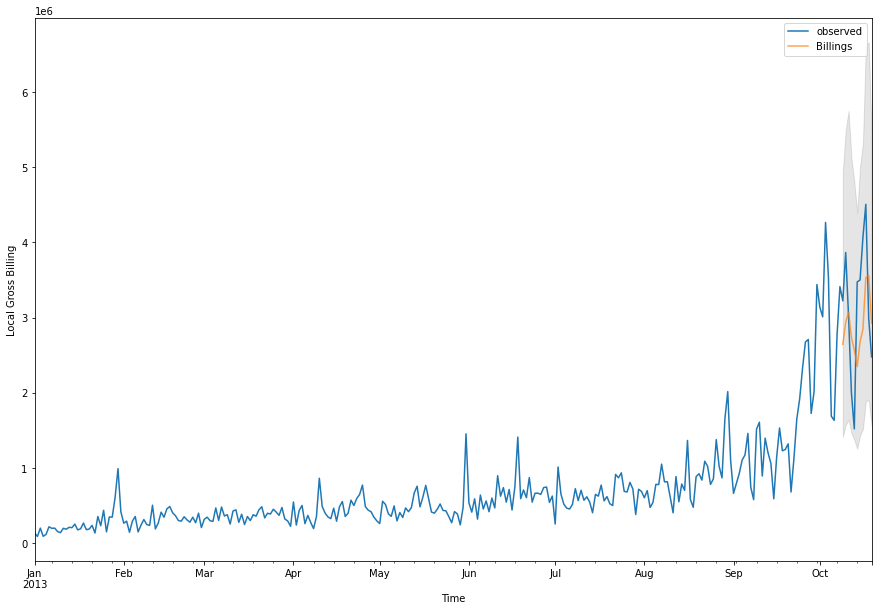

In [44]:
# To understand the accuracy of our forecasts, compare predicted local gross billing to real local gross billing of the time series, and set forecasts to start at 2013–10-09 to the end of the training data.
mean = result.get_prediction(start=pd.to_datetime("2013-10-09"),dynamic=False)

conf_int = np.exp(mean.conf_int())

training=lcp_ana['Billings']

mean= mean.predicted_mean.to_frame('Billings').rename_axis('time')
mean=np.exp(mean)
ax =training['2013':].plot(label='observed')
mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(15, 10))
ax.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Time')
ax.set_ylabel('Local Gross Billing')
plt.legend()
plt.show()

In [45]:
y_forecasted = mean
y_truth = pd.DataFrame(training['2013-10-09':])
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is Billings    7.065967e+11
dtype: float64


In [46]:
y_truth

,Billings
Start Date,
2013-10-09,3.222805e+06
2013-10-10,3.866735e+06
2013-10-11,3.015991e+06
2013-10-12,1.994842e+06
2013-10-13,1.519141e+06
2013-10-14,3.475041e+06
2013-10-15,3.501416e+06
2013-10-16,4.072212e+06
2013-10-17,4.507996e+06


In [47]:
# Create forecast object
forecast_object = result.get_forecast(steps=11)

# Extract prediction mean
pred= forecast_object.predicted_mean.to_frame('Billings').rename_axis('time')

# Extract the confidence intervals
ci = forecast_object.conf_int()

# Extract the forecast dates, for plotting
date = pred.index

# Take the exponential of the result to take it back to the original scale. 
# Estimated Oct 20 to Oct 30 2013 missing Gross Billing
pred = np.exp(pred)
pred

ci=np.exp(ci)


In [48]:
pred

,Billings
time,
2013-10-20,2.952528e+06
2013-10-21,3.211926e+06
2013-10-22,3.070535e+06
2013-10-23,3.057233e+06
2013-10-24,3.300862e+06
2013-10-25,3.319473e+06
2013-10-26,3.164603e+06
2013-10-27,3.275750e+06
2013-10-28,3.466517e+06


In [49]:
# Estimated missing gross billing from Oct 20th 2013 to Oct 30th 2013.
print("$",pred['Billings'].sum())

$ 35505895.512307696


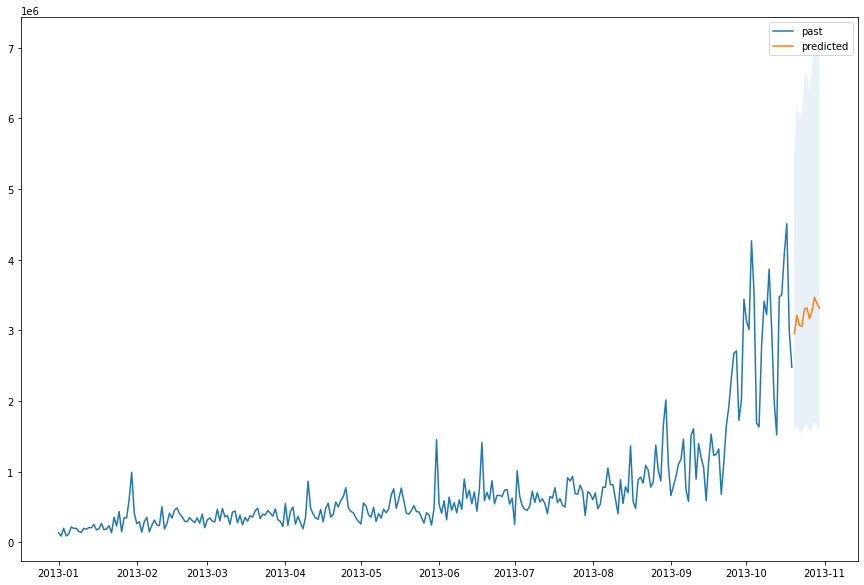

                Billings
time                    
2013-10-20  2.952528e+06
2013-10-21  3.211926e+06
2013-10-22  3.070535e+06
2013-10-23  3.057233e+06
2013-10-24  3.300862e+06
2013-10-25  3.319473e+06
2013-10-26  3.164603e+06
2013-10-27  3.275750e+06
2013-10-28  3.466517e+06
2013-10-29  3.376049e+06
2013-10-30  3.310419e+06
            lower Billings  upper Billings
2013-10-20    1.577590e+06    5.525782e+06
2013-10-21    1.664887e+06    6.196499e+06
2013-10-22    1.569910e+06    6.005557e+06
2013-10-23    1.539584e+06    6.070907e+06
2013-10-24    1.654384e+06    6.585949e+06
2013-10-25    1.659413e+06    6.640242e+06
2013-10-26    1.567183e+06    6.390264e+06
2013-10-27    1.607570e+06    6.675007e+06
2013-10-28    1.696534e+06    7.083111e+06
2013-10-29    1.644885e+06    6.929181e+06
2013-10-30    1.596676e+06    6.863557e+06


In [50]:
plt.figure()

# Plot past CO2 levels
plt.plot(lcp_ana.index, lcp_ana['Billings'], label='past')

# Plot the prediction means as line
plt.plot(date, pred, label='predicted')

# Shade between the confidence intervals
plt.fill_between(date, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

plt.gcf().set_size_inches((15, 10))
# Plot legend and show figure
plt.legend()
plt.show()

# Print all predicted mean
print(pred.iloc[0:])

# Print all 95% confidence interval
print(ci.iloc[0:])


In [51]:
# Join the prediction dataframe with the oringinal dataframe
tslocal_c=tslocal_d
flocal_d=pd.merge(tslocal_c,mean,how='left',left_index=True, right_index=True)

In [52]:
# Insert the prediction values from Oct 20th to Oct 30th to the original dataframe.
lb= flocal_d['Billings_x']
mb= pred['Billings']
# Relase those NAN values with prediction result
lb['2013-10-20':'2013-10-30']=mb['2013-10-20':'2013-10-30']
flocal_d['Billings_x']=lb
# Rename the Billings_x column with "Billings_Local" and drop the Billings_y column
flocal_d=flocal_d.drop(columns=['Billings_y'])
flocal_d=flocal_d.rename(columns={"Billings_x": "Billings_Local"})

In [53]:
# Calculate the Q4 2013 Total Gross Billings and total gross billings for local, travel and goods
QFourEst=flocal_d['Billings_Local'].sum()+tstravel_d['Billings'].sum()+tsgoods_d['Billings'].sum()
localb=flocal_d['Billings_Local'].sum()
travelb=tstravel_d['Billings'].sum()
goodsb=tsgoods_d['Billings'].sum()
print("Q42013 Estimated Total Gross Biling is: $",QFourEst)
print("Q42013 Estimated Gross Biling of Local is: $",localb)
print("Q42013 Estimated Gross Biling of Travel is: $",travelb)
print("Q42013 Estimated Gross Biling of Goods is: $",goodsb)

Q42013 Estimated Total Gross Biling is: $ 797520877.8096476
Q42013 Estimated Gross Biling of Local is: $ 444728012.9843076
Q42013 Estimated Gross Biling of Travel is: $ 70547395.7245
Q42013 Estimated Gross Biling of Goods is: $ 282245469.10084


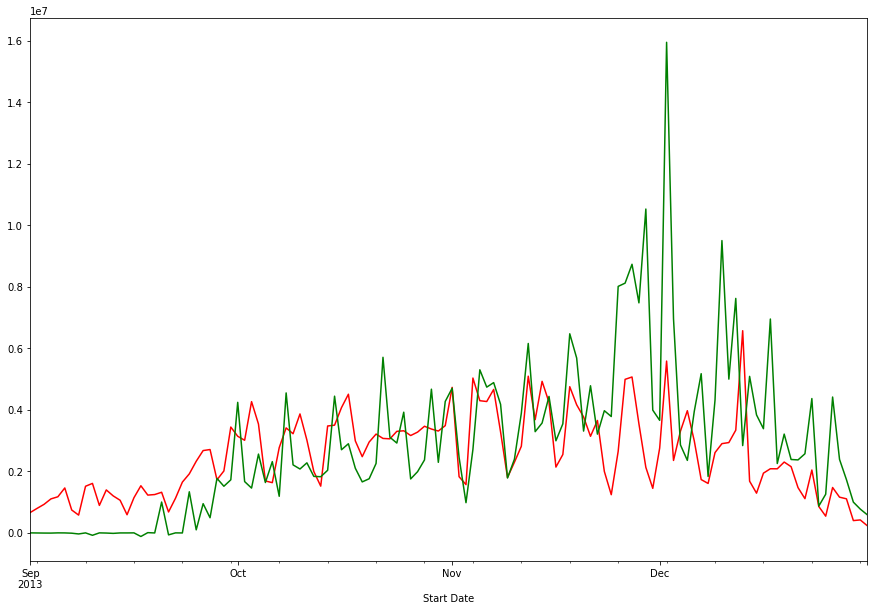

In [54]:
fc=flocal_d.loc['2013-09-01':'2013-12-31']
tgvp=tstg_d.loc['2013-09-01':'2013-12-31']

#lcp['Billings'].plot(color='b')
fc['Billings_Local'].plot(color='r')
tgvp['Billings'].plot(color='g')
plt.gcf().set_size_inches((15, 10))
plt.show()

In [55]:
# Using machine learning method to estimate the missing values
# Aggregate on date and plot to see the pattern
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from copy import copy

# Extract data from the original dataset.
seed=123
ML=copy(tslocal_d)
ML=ML.drop(columns=['Units Sold'])
ML['other_units_sold']=tstg_d['Units Sold']
ML['other_billing'] = tstg_d['Billings']
ML['DayofWeek']=ML.index.dayofweek
ML['week_of_year'] = ML.index.weekofyear
ML['month'] =ML.index.month

In [56]:
MLTf=ML.loc['2013-3-25':'2013-10-19']
MLTs= ML.loc['2013-10-31':'2013-12-31']
MLP = ML.loc['2013-10-20':'2013-10-30']

Text(0, 0.5, 'Billing')

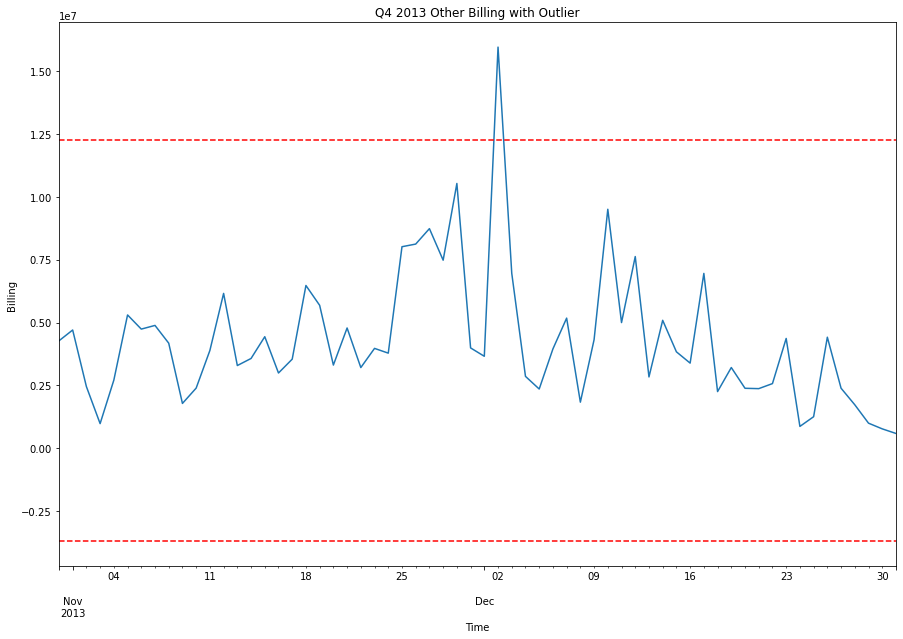

In [57]:
# Indicates the outlier's in the dataset
fig, axs = plt.subplots(figsize=(15, 10))

# Calculate the mean / standard deviation for the data
ob_mean = MLTs['other_billing'].mean()
ob_std = MLTs['other_billing'].std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
MLTs['other_billing'].plot(ax=axs)
axs.axhline(ob_mean + ob_std * 3, ls='--', c='r')
axs.axhline(ob_mean - ob_std * 3, ls='--', c='r')
plt.title('Q4 2013 Other Billing with Outlier')
plt.xlabel('Time')
plt.ylabel('Billing')

Text(0, 0.5, 'Units Sold')

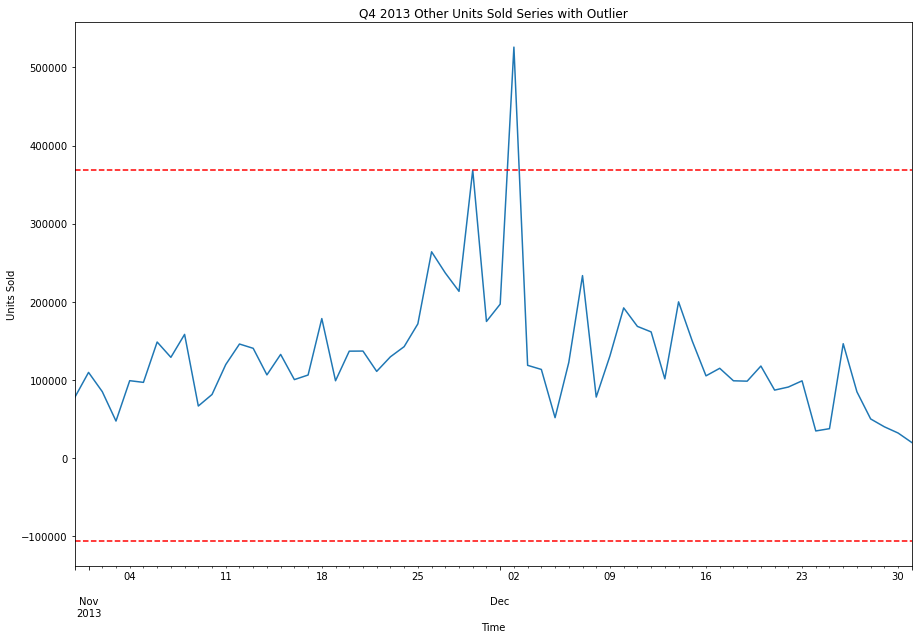

In [58]:
# Indicates the outlier's in the dataset
fig, axs = plt.subplots(figsize=(15, 10))

# Calculate the mean / standard deviation for the data
ous_mean = MLTs['other_units_sold'].mean()
ous_std = MLTs['other_units_sold'].std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
MLTs['other_units_sold'].plot(ax=axs)
axs.axhline(ous_mean + ous_std * 3, ls='--', c='r')
axs.axhline(ous_mean - ous_std * 3, ls='--', c='r')
plt.title('Q4 2013 Other Units Sold Series with Outlier')
plt.xlabel('Time')
plt.ylabel('Units Sold')

Text(0, 0.5, 'Billing')

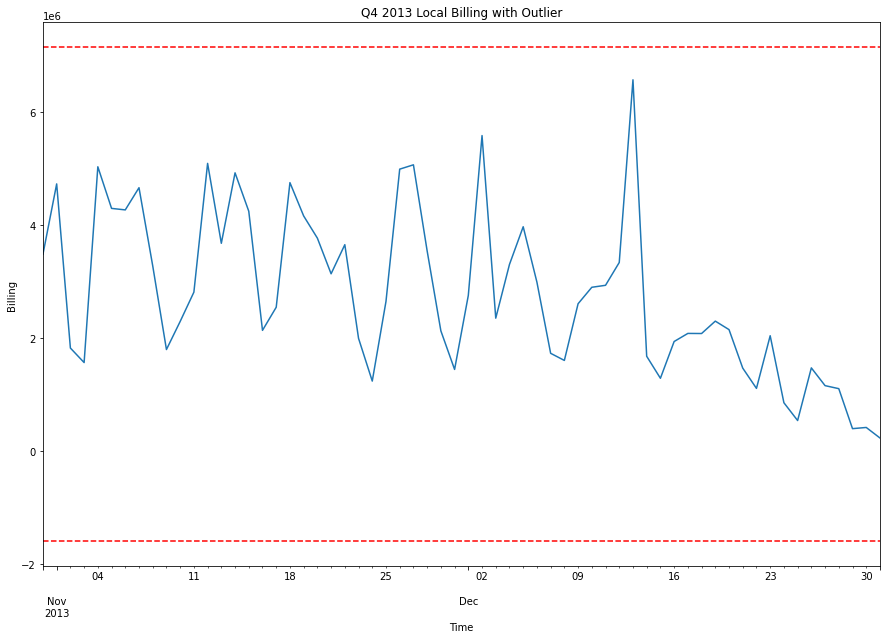

In [59]:
# Indicates the outlier's in the dataset
fig, axs = plt.subplots(figsize=(15, 10))

# Calculate the mean / standard deviation for the data
b_mean = MLTs['Billings'].mean()
b_std = MLTs['Billings'].std()
# Plot the data, with a window that is 3 standard deviations
# around the mean
MLTs['Billings'].plot(ax=axs)
axs.axhline(b_mean + b_std * 3, ls='--', c='r')
axs.axhline(b_mean - b_std * 3, ls='--', c='r')
plt.title('Q4 2013 Local Billing with Outlier')
plt.xlabel('Time')
plt.ylabel('Billing')

In [60]:
# Combine the November to December data with the data before Octobor 20th 2013, because here the effect of time is allocated to weekday, dayofweek and weekofyear variabels.
# Even without index, the model can still capture the pattern.
MLA=MLTf.append(MLTs,ignore_index=True)
E=pd.DataFrame()
MLP=MLP.append(E,ignore_index=True)

In [61]:
# Random Forest grid search to obtain the best model (smallest mean square error)
def brf(X,y):
    
    SEED=123
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=SEED)

    rf= RandomForestRegressor(random_state=SEED)

    params_rf={'n_estimators':[50,100,150],
              'max_depth': [5,6,7],
              'min_samples_leaf':[5,6,7,8,9,10,20],
              'min_samples_split':[5,6,7,8,9,10,20],
              'max_features': ['log2','sqrt']}

    grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       verbose=1,
                       n_jobs=-1)
    
    
    grid_rf.fit(X_train,y_train)
    
    best_par=grid_rf.best_params_
    print('Best hyperparameters:\n', best_par)
    
    
    best_model=grid_rf.best_estimator_
    y_pred = best_model.predict(X_test)
    mse_test=MSE(y_test,y_pred)
    print("Test set MSE of rf: {:.2f}". format(mse_test))
       

# Show the importance of the explanatory variables
    importances_rf=pd.Series(best_model.feature_importances_, index=X.columns)
    sorted_importances_rf = importances_rf.sort_values()
    sorted_importances_rf.plot(kind='barh',color='lightgreen'); plt.show()

Fitting 10 folds for each of 882 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 | elapsed:  7.8min finished


Best hyperparameters:
 {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Test set MSE of rf: 381821853520.01


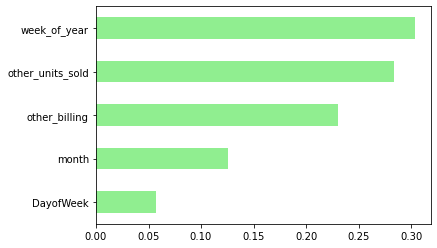

In [62]:
# Train a random forest model
Xf=MLA.iloc[:,1:6]
yf=MLA.iloc[:,0]
brf(Xf,yf)
# As you can see other_units_sold is and other_billing are significant variables for this random forest model.
# The smallest mean square erro is 3.12E+11. And the best hyperparameters for this random forest model are shown below.

In [63]:
Xf=MLA.iloc[:,1:6]
yf=MLA.iloc[:,0]

In [64]:
Ximpute =MLP.iloc[:,1:6]
SEED=1
#Best hyperparameter
optrf=RandomForestRegressor(n_estimators=100, min_samples_leaf = 5, min_samples_split=5, max_features='log2', max_depth=5, random_state=SEED)

optrf.fit(Xf,yf)
yimpute=optrf.predict(Ximpute)

In [65]:
TTL=tslocal_d['Billings'].sum()+yimpute.sum()
TTQ=tslocal_d['Billings'].sum()+yimpute.sum()+tstravel_d['Billings'].sum()+tsgoods_d['Billings'].sum()
print("Q42013 Estimated Total Gross Biling is: $",TTQ)
print("Q42013 Estimated Gross Biling of Local is: $",TTL)
print("Q42013 Estimated Gross Biling of Travel is: $",travelb)
print("Q42013 Estimated Gross Biling of Goods is: $",goodsb)

Q42013 Estimated Total Gross Biling is: $ 796819027.2199552
Q42013 Estimated Gross Biling of Local is: $ 444026162.3946153
Q42013 Estimated Gross Biling of Travel is: $ 70547395.7245
Q42013 Estimated Gross Biling of Goods is: $ 282245469.10084


In [66]:
# Gradient boosting grid search to obtain the best model (smallest mean square error)
def bgb(X,y):
    
    SEED=1
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=SEED)

    gb= GradientBoostingRegressor(random_state=SEED)

    params_gb={'n_estimators':[500,1000,1500],
              'max_depth': [2,4,6,8],
              'min_samples_leaf':[1,5,10,15],
              'min_samples_split':[1,5,10,15],
              'max_features': ['log2','sqrt'],
              'learning_rate':[0.01,0.05,0,1]}

    grid_gb = GridSearchCV(estimator=gb,
                       param_grid=params_gb,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       verbose=1,
                       n_jobs=-1)
    
    
    grid_gb.fit(X_train,y_train)
    
    best_par=grid_gb.best_params_
    print('Best hyperparameters:\n', best_par)
    
    
    best_model=grid_gb.best_estimator_
    y_pred = best_model.predict(X_test)
    mse_test=MSE(y_test,y_pred)
    print("Test set RMSE of rf: {:.2f}". format(mse_test))
    
    importances_rf=pd.Series(best_model.feature_importances_, index=X.columns)
    sorted_importances_rf = importances_rf.sort_values()
    sorted_importances_rf.plot(kind='barh',color='lightgreen'); plt.show()

Fitting 10 folds for each of 1536 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1628 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2288 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3920 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 5050 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 7538 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 12840 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 14444 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed: 15.8min finished


Best hyperparameters:
 {'learning_rate': 0.01, 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Test set RMSE of rf: 295413693710.25


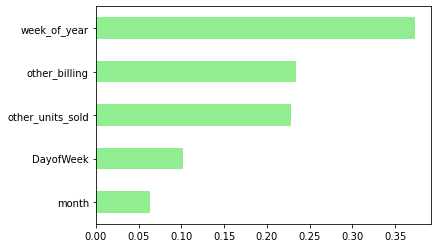

In [67]:
# Build a model with the previous data
Xtgb=MLA.iloc[:,1:6]
ytgb=MLA.iloc[:,0]
bgb(Xtgb,ytgb)

In [68]:
Xgb =MLP.iloc[:,1:6]
SEED=1
optgb=GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, min_samples_leaf = 1, max_features='log2', min_samples_split= 5, max_depth=2, random_state=SEED)

optgb.fit(Xtgb,ytgb)
ygb=optgb.predict(Xgb)
GBTL=tslocal_d['Billings'].sum()+ygb.sum()
GBTQ=tslocal_d['Billings'].sum()+ygb.sum()+tstravel_d['Billings'].sum()+tsgoods_d['Billings'].sum()
print("Q42013 Estimated Total Gross Biling is: $",GBTQ)
print("Q42013 Estimated Gross Biling of Local is: $",GBTL)
print("Q42013 Estimated Gross Biling of Travel is: $",travelb)
print("Q42013 Estimated Gross Biling of Goods is: $",goodsb)

Q42013 Estimated Total Gross Biling is: $ 797821005.6524587
Q42013 Estimated Gross Biling of Local is: $ 445028140.82711864
Q42013 Estimated Gross Biling of Travel is: $ 70547395.7245
Q42013 Estimated Gross Biling of Goods is: $ 282245469.10084


In [69]:
def dt(X,y):
    SEED=123
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=SEED)

    dt= DecisionTreeRegressor(random_state=SEED)

    params_dt={
              'max_depth': [2,4,6,8],
              'min_samples_leaf':[5,6,7,8,9,10,20],
              'min_samples_split':[5,6,7,8,9,10,20],
              'max_leaf_nodes': [100,500,1000]}

    grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       )
    
    
    grid_dt.fit(X_train,y_train)
    
    best_par=grid_dt.best_params_
    print('Best hyperparameters:\n', best_par)
    
    
    best_model=grid_dt.best_estimator_
    y_pred = best_model.predict(X_test)
    mse_test=MSE(y_test,y_pred)
    print("Test set MSE of rf: {:.2f}". format(mse_test))
       

# Show the importance of the explanatory variables
    importances_dt=pd.Series(best_model.feature_importances_, index=X.columns)
    sorted_importances_dt = importances_dt.sort_values()
    sorted_importances_dt.plot(kind='barh',color='lightgreen'); plt.show()

Best hyperparameters:
 {'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 5, 'min_samples_split': 20}
Test set MSE of rf: 391476706325.92


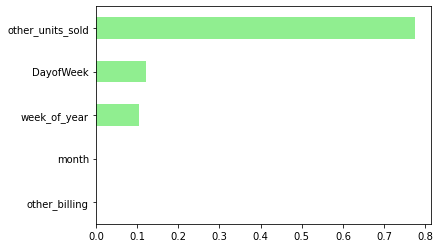

In [70]:
# Train a decision tree model
Xdd=MLA.iloc[:,1:6]
ydd=MLA.iloc[:,0]
dt(Xdd,ydd)
# As you can see other_units_sold is and other_billing are significant variables for this random forest model.
# The smallest mean square erro is 3.12E+11. And the best hyperparameters for this random forest model are shown below.

In [71]:
Xdt =MLP.iloc[:,1:6]
SEED=123
optdt=DecisionTreeRegressor(min_samples_leaf = 5, max_leaf_nodes=100, min_samples_split= 20, max_depth=8, random_state=SEED)

optdt.fit(Xdd,ydd)
ydt=optdt.predict(Xdt)
DTTL=tslocal_d['Billings'].sum()+ydt.sum()
DTTQ=tslocal_d['Billings'].sum()+ydt.sum()+tstravel_d['Billings'].sum()+tsgoods_d['Billings'].sum()
print("Q42013 Estimated Total Gross Biling is: $",DTTQ)
print("Q42013 Estimated Gross Biling of Local is: $",DTTL)
print("Q42013 Estimated Gross Biling of Travel is: $",travelb)
print("Q42013 Estimated Gross Biling of Goods is: $",goodsb)

Q42013 Estimated Total Gross Biling is: $ 798834439.45039
Q42013 Estimated Gross Biling of Local is: $ 446041574.62505
Q42013 Estimated Gross Biling of Travel is: $ 70547395.7245
Q42013 Estimated Gross Biling of Goods is: $ 282245469.10084
